In [1]:
#Importing the libraries

from __future__ import print_function

import pandas as pd
import numpy as np
import os

# Pytorch modules used in my code.
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Softmax
from torchvision import transforms
from torchvision import datasets

# These modules are which I've used for data pre processing and results visulaization.
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix
from matplotlib import pyplot as plt

# This is just for interfacing the training progress.
# from tqdm.autonotebook import tqdm

In [9]:
class classifier(nn.Module):
  def __init__(self):
    super(classifier, self).__init__()
    self.layer1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
                                nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2))
    self.drop_out = nn.Dropout(p=0.6)
    self.fc1 = nn.Linear(7 * 7 * 64, 1000)
    self.fc2 = nn.Linear(1000, 10)
  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = x.reshape(x.size(0), -1)
    x = self.drop_out(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

# Train the model
def training(train_dataloader, model, learning_rate, num_epochs,optimizer = "SGD", validation = False, validation_loader = None, plots = False):

  log_train_loss = []
  log_train_accuracy = []
  log_valid_loss = []
  log_valid_accuracy = []
  epoch_plot_values = []
  # Loss and optimizer
  criterion = nn.CrossEntropyLoss()
  if(optimizer == "SGD"):
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=learning_rate/4)
  elif(optimizer == "adam"):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  for epoch in range(num_epochs):
    train_mean_loss = 0
    train_mean_acc = 0
    for i, (train_images, train_label) in enumerate(train_dataloader):
        # Run the forward pass
        train_output = model(train_images)
        loss = criterion(train_output, train_label)
        train_mean_loss +=loss.item()

        train_acc = calc_accuracy(train_output,train_label)
        train_mean_acc += train_acc 
        
        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if(validation == True):
          with torch.no_grad():
            valid_mean_loss = 0
            valid_mean_acc = 0
            for valid_input,valid_label in valid_loader:
              # valid_input = valid_input.to(device_available)
              # valid_label = valid_label.to(device_available)
              valid_output = model(valid_input.type(torch.FloatTensor))
              valid_loss = loss_CE(train_output,train_label)
              valid_acc = calc_accuracy(valid_output,valid_label)
              valid_mean_acc += valid_acc
              valid_mean_loss += valid_loss.item() 

    log_train_loss.append((train_mean_loss/len(train_dataloader)))
    log_train_accuracy.append((train_mean_acc/len(train_dataloader)))
    if(validation == True):
      log_valid_loss.append((valid_mean_loss/len(valid_loader)))
      log_valid_accuracy.append((valid_mean_acc/len(valid_loader)))

    epoch_plot_values.append(epoch)
    
    print("Epoch:",epoch)
    print("Training Loss:",train_mean_loss/len(train_dataloader))
    print("Training accuracy:", (train_mean_acc/len(train_dataloader)), "%")
    if(validation == True):
      print("Validation loss:", valid_mean_loss/len(valid_loader))
      print("Valdation Accuracy:", valid_mean_acc/len(valid_loader),"%")
    print("*******************************************************")
    ############################ Early_stopping_condtion ############
    if(validation == True): 
      if((valid_mean_acc/len(valid_loader)) == 100):
        print("Validation accuracy reached 100%, stopping early.")
        break
      elif(len(log_valid_loss)>20):
        if(log_valid_loss[-20]<(sum(log_valid_loss[-20:])/20)):
          print(sum(log_valid_loss[-20:])/20)
          print("Validation loss started to increase, stopping early.")
          break

  if(plots == True):
    f1 = plt.figure(1)
    ax1 = f1.add_subplot(111)

    f2 = plt.figure(2)
    ax2 = f2.add_subplot(111)

    ax1.plot(epoch_plot_values,log_train_loss, '-b', label = 'Train loss')
    if(validation == True):
        ax1.plot(epoch_plot_values,log_valid_loss, '-r', label = 'Validation loss')
        ax1.set_title("Train and Validation losses")
    else:
        ax1.set_title("Train loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(epoch_plot_values,log_train_accuracy, '-b', label = 'Train Accuracy')
    if(validation == True):
        ax2.plot(epoch_plot_values,log_valid_accuracy, '-r', label = 'Validation Accuracy')
        ax2.set_title("Train and Validation accuracy")
    else:
        ax2.set_title("Train accuracy")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")

    plt.legend()
    plt.show()
  
def calc_accuracy(prediction_tensor, true_val_tensor):
  # This function is just to calculate the accuracy given the prediction and the true value of a batch of data.
  prediction_tensor = torch.log_softmax(prediction_tensor, dim = 1)
  _, max_idx = torch.max(prediction_tensor, dim = 1)

  true_val = true_val_tensor.tolist()
  predicted_val = max_idx.cpu().numpy()

  correct_count = 0
  for i in range(len(true_val)):
      
      if(predicted_val[i]==true_val[i]):
          correct_count += 1

  accuracy = (correct_count / len(true_val))*100 
  return accuracy
  


def confusion_matrix_plot(c_matrix, classes, title = "Confusion Matrix", bg_color = "silver"):
  # This function if for plotting the confusion matrix.
      
  c_map=plt.cm.Greys
  plt.imshow(c_matrix, interpolation='nearest', cmap=c_map)

  plt.gcf().set_facecolor(bg_color)
  plt.title(title)

  axes = np.arange(len(classes))

  plt.xticks(axes, classes, rotation=45)
  plt.yticks(axes, classes)

  plt.ylabel(' True Image Label')
  plt.xlabel('\n Predicted Label')

  thresh = c_matrix.max() / 2.

  for i in range((c_matrix.shape[0])):
      for j in range((c_matrix.shape[1])):
          if c_matrix[i, j] > thresh:
              text_color = "white"  
          else:
              text_color = "black"
          plt.text(j, i, c_matrix[i, j], horizontalalignment="center", color = text_color)
  plt.show()

def prediction(test_dataloader, model):
  # This function is for predicting with help of the trained model.
  correct_label = []
  prediction_dataset = []
  with torch.no_grad():
    model.eval()
    test_accuracy = 0
    for i,(test_input,label) in enumerate(test_dataloader):
      output = model(test_input.type(torch.FloatTensor))
      accuracy = calc_accuracy(output,label)
      test_accuracy += accuracy
      output = torch.log_softmax(output, dim = 1)
      _, max_idx = torch.max(output, dim = 1)
      prediction_dataset.append(max_idx.cpu().numpy())
      correct_label.append(label.tolist())
          
  prediction_dataset = [pred.squeeze().tolist() for pred in prediction_dataset]
  # print(prediction_dataset)
  # print(correct_label)
  print("Accuracy: ",  test_accuracy/len(test_dataloader))
  return prediction_dataset, correct_label

In [3]:
# transforms to apply to the data
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

path_data = "/content"

# MNIST dataset
train_dataset = datasets.MNIST(root=path_data, train=True, transform=trans, download=True)
test_dataset = datasets.MNIST(root=path_data, train=False, transform=trans)

In [4]:
model = classifier()
batch_size = 100

# Changing device to GPU if available.
# model = model.to(device_available)
if(os.path.exists("valid.csv")):
    print("Valid.csv found, so validation would be there in training.")
    valid_dataset = my_dataset_class('valid.csv')
    valid_loader = DataLoader(valid_dataset,batch_size = 2, shuffle=True)
    print("Valid Loader", len(valid_loader))
    train_set_name = "train_valid.csv"
else:
    print("No Valid.csv found, so no validation in training.")
    train_set_name = "train.csv"

# train_dataset = my_dataset_class(train_set_name)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
print("Train Loader", len(train_loader))


# test_dataset = my_dataset_class("test.csv")
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
print("Test Loader", len(test_loader))

No Valid.csv found, so no validation in training.
Train Loader 600
Test Loader 100


In [15]:
# Hyperparameters
num_epochs = 5
batch_size = 50
num_classes = 10
batch_size = 100
learning_rate = 0.01
path_model_final_save = "/content/"
torch.save(model.state_dict(), path_model_final_save + 'conv_net_model.ckpt')

Epoch: 0
Training Loss: 0.013540767978750713
Training accuracy: 99.605 %
*******************************************************
Epoch: 1
Training Loss: 0.012976791315353087
Training accuracy: 99.62666666666667 %
*******************************************************
Epoch: 2
Training Loss: 0.012470145530824085
Training accuracy: 99.645 %
*******************************************************
Epoch: 3
Training Loss: 0.012056321338556397
Training accuracy: 99.66 %
*******************************************************
Epoch: 4
Training Loss: 0.011632215110512333
Training accuracy: 99.67666666666666 %
*******************************************************


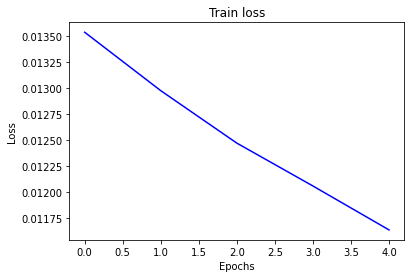

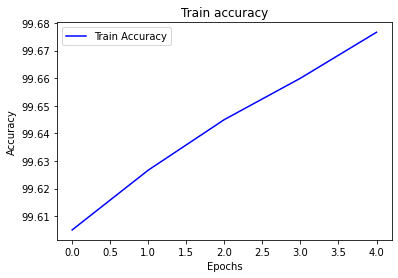

In [16]:
training(train_loader,model, learning_rate, num_epochs,optimizer = "SGD", plots = True)

# Save the model and plot
torch.save(model.state_dict(), path_model_final_save + 'conv_net_model.ckpt')

Accuracy:  99.33
 
[[ 977    0    0    0    0    0    1    1    1    0]
 [   0 1132    1    1    0    0    1    0    0    0]
 [   0    1 1029    0    0    0    0    1    1    0]
 [   0    0    1 1006    0    2    0    0    1    0]
 [   0    0    0    0  979    0    0    0    2    1]
 [   1    0    0    4    0  885    1    0    0    1]
 [   3    2    0    1    2    3  945    0    2    0]
 [   0    3    2    1    0    0    0 1019    1    2]
 [   3    0    2    1    0    1    0    1  964    2]
 [   1    0    0    0    4    3    0    2    2  997]]
 


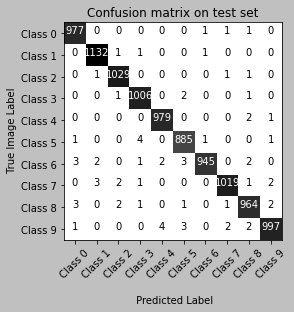

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.99      1.00      1.00      1032
           3       0.99      1.00      0.99      1010
           4       0.99      1.00      1.00       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       1.00      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [17]:
# Testing cell
# Confusion matrix plot and some other metrics like recall, precision and accuracy.

b_s = test_loader.batch_size
length_loader = len(test_loader)
prediction_dataset, correct_label = prediction(test_loader, model)
length_prediction = b_s*length_loader

prediction_dataset = np.array(prediction_dataset)
prediction_dataset.resize([1,length_prediction])
prediction_dataset.squeeze()
prediction_dataset = prediction_dataset.tolist()
prediction_dataset = prediction_dataset[0]


correct_label = np.array(correct_label)
correct_label.resize([1,length_prediction])
correct_label.squeeze()
correct_label = correct_label.tolist()
correct_label = correct_label[0]

c_matrix = (confusion_matrix(correct_label, prediction_dataset,labels= [0,1,2,3,4,5,6,7,8,9]))

print(" ")
print(c_matrix)
print(" ")
classes = ["Class 0","Class 1","Class 2","Class 3","Class 4","Class 5","Class 6","Class 7","Class 8","Class 9"]
confusion_matrix_plot(c_matrix, classes , title="Confusion matrix on test set" )
print(classification_report(correct_label, prediction_dataset))
